In [ ]:
! pip install fastdtw -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA

# Statistical tests and diagnostics
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from scipy.stats import ttest_ind, norm, stats

# Peak finding
from scipy.signal import find_peaks

# Machine learning
import xgboost as xgb

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

# Forecasting
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Distance metrics
from fastdtw import fastdtw

In [ ]:
## Create Dataset

In [ ]:
import random
import numpy as np
import pandas as pd

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Generate a date range for 3 years
dates = pd.date_range(start="2016-01-01", end="2019-12-31", freq="D")

# Create dummy weather data (Sunny or Rainy)
weather = [random.choice(["Sunny", "Rainy"]) for _ in range(len(dates))]

# Mark weekends (Saturday/Sunday)
day_of_week = [date.weekday() for date in dates]
weekend = [1 if day in [5, 6] else 0 for day in day_of_week]

# Mark festival seasons (e.g., Jan for Pongal, Oct-Nov for Diwali)
festival_season = [1 if (date.month in [1, 10, 11] and random.random() > 0.3) else 0 for date in dates]

# Mark special events randomly
special_event = [1 if random.random() > 0.9 else 0 for _ in dates]

# Generate footfall based on conditions
footfall = []
for i in range(len(dates)):
    base = 50  # Base footfall

    # Add factors
    if weather[i] == "Sunny":
        base += 20
    if weekend[i] == 1:
        base += 30
    if festival_season[i] == 1:
        base += 100
    if special_event[i] == 1:
        base += 50

    # Add some random noise
    base += np.random.normal(0, 10)

    # Ensure no negative footfall
    footfall.append(max(0, int(base)))

# Create the DataFrame
data = pd.DataFrame({
    "Date": dates,
    "Weather": weather,
    "Weekend": weekend,
    "Festival_Season": festival_season,
    "Special_Event": special_event,
    "Footfall": footfall
})

# Display the first few rows of the data
print(data.head())

# Optionally save the data to a CSV file
data.to_csv("footfall_data_3_years.csv", index=False)


        Date Weather  Weekend  Festival_Season  Special_Event  Footfall
0 2016-01-01   Sunny        0                1              1       224
1 2016-01-02   Sunny        1                1              0       198
2 2016-01-03   Rainy        1                1              0       186
3 2016-01-04   Sunny        0                1              0       185
4 2016-01-05   Sunny        0                1              0       167


In [ ]:
data.to_csv("Football_village_.csv",index=False)

In [ ]:
## Better Visualisation

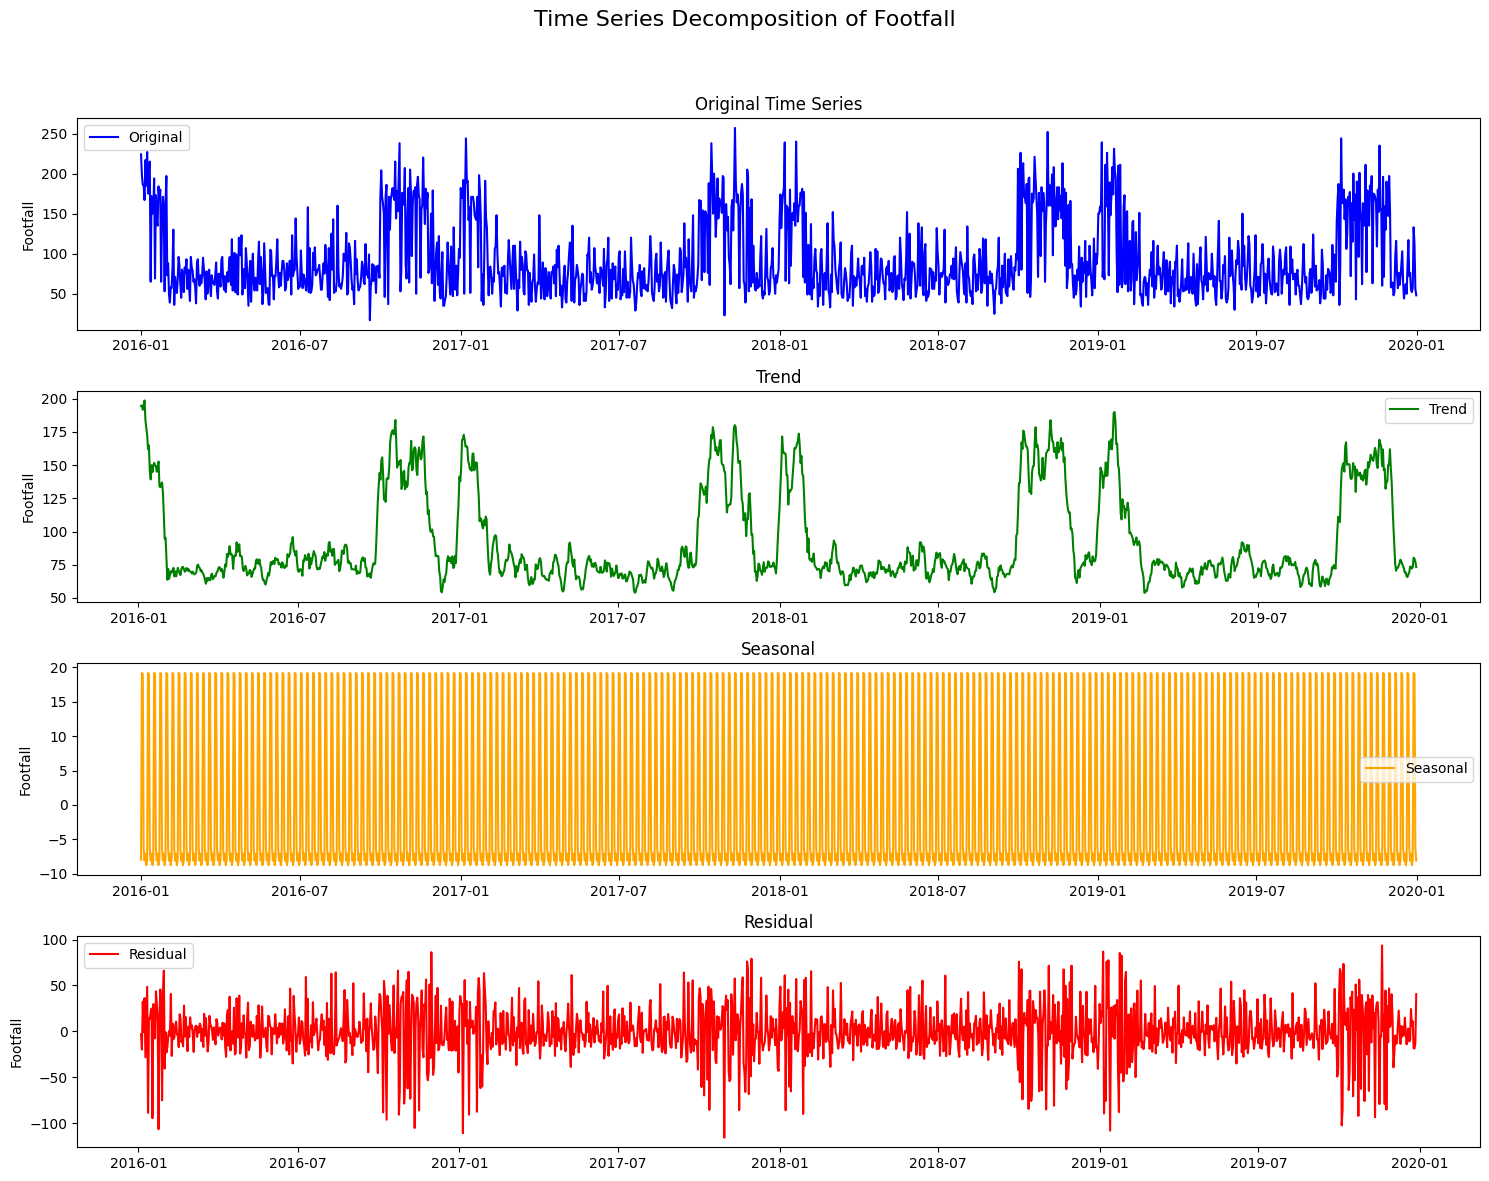

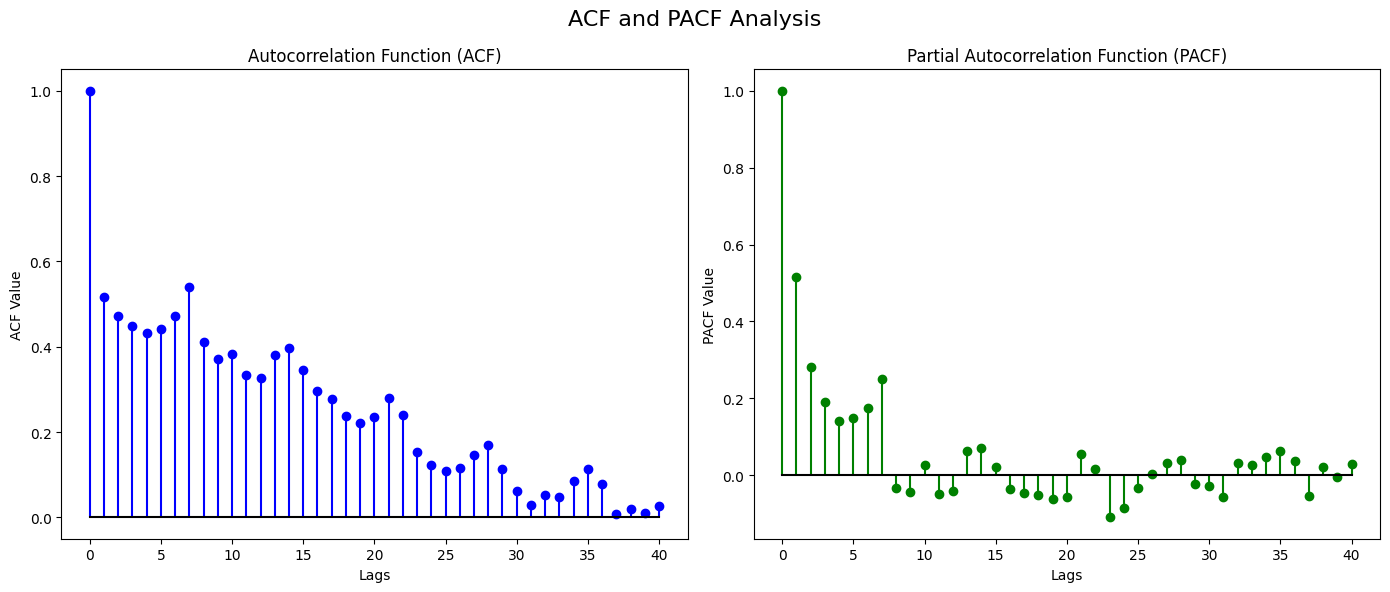

<ipython-input-8-aec66e86a8d1>:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),


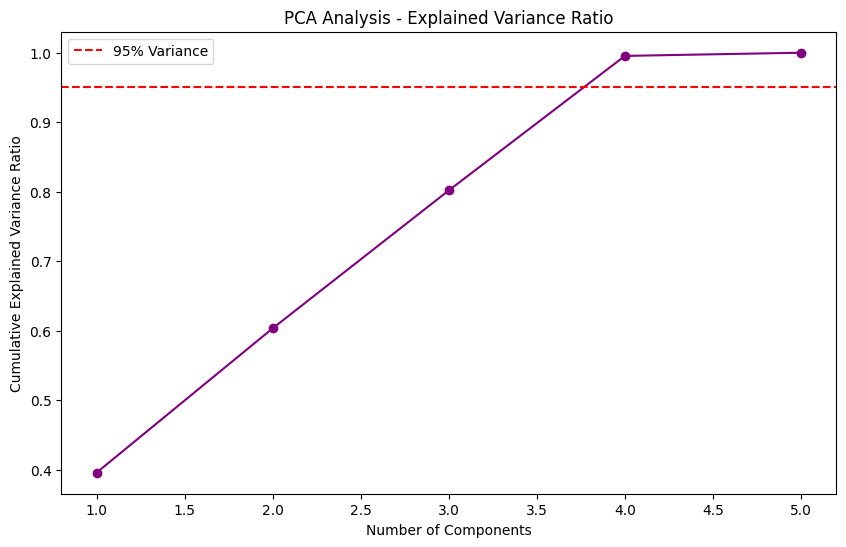

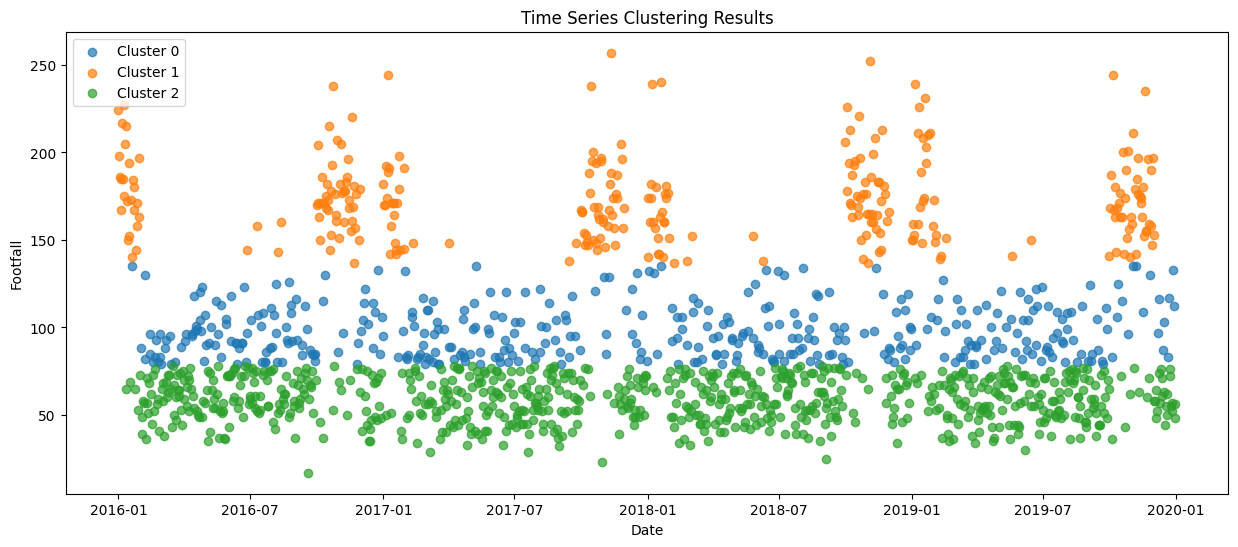

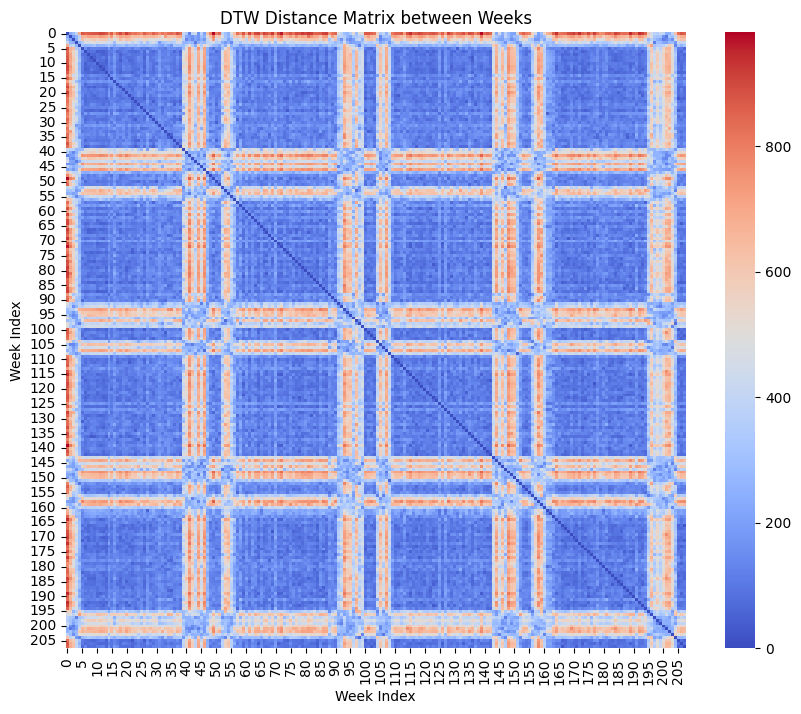

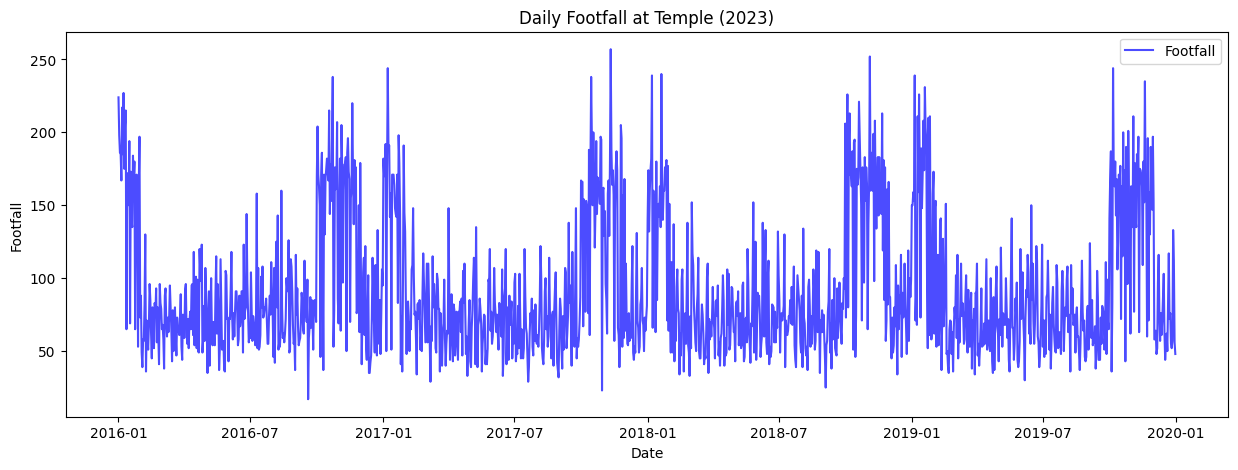

        Date Weather  Weekend  Festival_Season  Special_Event  Footfall
0 2016-01-01   Sunny        0                1              1       224
1 2016-01-02   Sunny        1                1              0       198
2 2016-01-03   Rainy        1                1              0       186
3 2016-01-04   Sunny        0                1              0       185
4 2016-01-05   Sunny        0                1              0       167


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from fastdtw import fastdtw
import seaborn as sns
from datetime import timedelta

# 1. Time Series Decomposition
def perform_decomposition(data):
    decomposition = seasonal_decompose(data['Footfall'], period=7)

    plt.figure(figsize=(15, 12))
    plt.suptitle('Time Series Decomposition of Footfall', fontsize=16)

    plt.subplot(411)
    plt.plot(data['Date'], data['Footfall'], label='Original', color='blue')
    plt.title('Original Time Series')
    plt.ylabel('Footfall')
    plt.legend()

    plt.subplot(412)
    plt.plot(data['Date'], decomposition.trend, label='Trend', color='green')
    plt.title('Trend')
    plt.ylabel('Footfall')
    plt.legend()

    plt.subplot(413)
    plt.plot(data['Date'], decomposition.seasonal, label='Seasonal', color='orange')
    plt.title('Seasonal')
    plt.ylabel('Footfall')
    plt.legend()

    plt.subplot(414)
    plt.plot(data['Date'], decomposition.resid, label='Residual', color='red')
    plt.title('Residual')
    plt.ylabel('Footfall')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return decomposition

# 2. ACF and PACF Analysis
def plot_acf_pacf(data, lags=40):
    acf_values = acf(data['Footfall'], nlags=lags)
    pacf_values = pacf(data['Footfall'], nlags=lags)

    plt.figure(figsize=(14, 6))
    plt.suptitle('ACF and PACF Analysis', fontsize=16)

    plt.subplot(121)
    plt.stem(range(len(acf_values)), acf_values, linefmt='blue', markerfmt='bo', basefmt='black')
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lags')
    plt.ylabel('ACF Value')

    plt.subplot(122)
    plt.stem(range(len(pacf_values)), pacf_values, linefmt='green', markerfmt='go', basefmt='black')
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lags')
    plt.ylabel('PACF Value')

    plt.tight_layout()
    plt.show()

# 3. PCA Analysis
def perform_pca(data):
    features = ['Footfall', 'Weekend', 'Festival_Season', 'Special_Event']
    X = data[features].copy()
    X['Weather_numeric'] = (data['Weather'] == 'Sunny').astype(int)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA()
    pca_result = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_), 'bo-', color='purple')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Analysis - Explained Variance Ratio')
    plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance')
    plt.legend()
    plt.show()

    return pca, pca_result

# 4. Time Series Clustering
def perform_clustering(data, n_clusters=3):
    X = data[['Footfall']].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)

    plt.figure(figsize=(15, 6))
    colors = sns.color_palette("tab10", n_clusters)

    for i in range(n_clusters):
        mask = clusters == i
        plt.scatter(data.loc[mask, 'Date'],
                    data.loc[mask, 'Footfall'],
                    label=f'Cluster {i}',
                    color=colors[i],
                    alpha=0.7)

    plt.title('Time Series Clustering Results')
    plt.xlabel('Date')
    plt.ylabel('Footfall')
    plt.legend()
    plt.show()

    return clusters

# 5. DTW Analysis
def compute_dtw_matrix(data, window_size=7):
    weekly_patterns = []
    current_date = data['Date'].min()

    while current_date + timedelta(days=6) <= data['Date'].max():
        week_data = data[(data['Date'] >= current_date) &
                         (data['Date'] < current_date + timedelta(days=7))]
        weekly_patterns.append(week_data['Footfall'].values)
        current_date += timedelta(days=7)

    n_weeks = len(weekly_patterns)
    dtw_matrix = np.zeros((n_weeks, n_weeks))

    for i in range(n_weeks):
        for j in range(i+1, n_weeks):
            distance, _ = fastdtw(weekly_patterns[i], weekly_patterns[j])
            dtw_matrix[i, j] = distance
            dtw_matrix[j, i] = distance

    plt.figure(figsize=(10, 8))
    sns.heatmap(dtw_matrix, cmap='coolwarm', annot=False)
    plt.title('DTW Distance Matrix between Weeks')
    plt.xlabel('Week Index')
    plt.ylabel('Week Index')
    plt.show()

    return dtw_matrix, weekly_patterns

# Perform analyses
decomp = perform_decomposition(data)
plot_acf_pacf(data)
pca, pca_result = perform_pca(data)
clusters = perform_clustering(data)
dtw_matrix, weekly_patterns = compute_dtw_matrix(data)

# Summary and quick visualization
plt.figure(figsize=(15, 5))
plt.plot(data["Date"], data["Footfall"], label="Footfall", color="blue", alpha=0.7)
plt.title("Daily Footfall at Temple (2023)")
plt.xlabel("Date")
plt.ylabel("Footfall")
plt.legend()
plt.show()

# Display the first few rows of the dataset
print(data.head())

In [ ]:
## Statistical testing


1. Data Cleaning Results:
Found 56 outliers in Footfall data. These have been capped at -23.00 (lower) and 193.00 (upper)

2. Stationarity Analysis:

            Stationarity Test Results:
            -------------------------
            Your footfall data is stationary, meaning it's suitable for many statistical analyses.
            Technical details:
            - ADF Statistic: -5.9817
            - p-value: 0.0000
            

3. Weekend vs Weekday Analysis:

            Weekend vs Weekday Analysis:
            ---------------------------
            There is a significant difference in footfall between weekends and weekdays. Footfall is higher during weekends.

            Average footfall:
            - Weekends: 109.85
            - Weekdays: 84.41
            - Difference: 25.43

            Statistical details:
            - T-statistic: 10.2115
            - p-value: 0.0000
            

4. Distribution Analysis:

            Distribution Analysis:
            -----------

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



            Granger Causality Test Results:
            -----------------------------
            What this means: This test helps identify if one variable helps predict another.

            Findings:
            - Weekend appears to have a causal relationship with Footfall
- Festival_Season appears to have a causal relationship with Footfall
- Special_Event appears to have a causal relationship with Footfall
- Weather_Sunny appears to have a causal relationship with Footfall

            Technical details:
                        Weekend  Festival_Season  Special_Event  Weather_Sunny
lag_1  3.177521e-02     2.669372e-32   2.962764e-14   2.971493e-07
lag_2  1.722343e-23     5.157440e-40   1.891367e-10   7.313515e-07
lag_3  5.172579e-26     1.352615e-35   6.562395e-08   2.790729e-05
lag_4  3.656397e-36     2.128530e-35   8.131508e-07   3.353055e-04
lag_5  4.460681e-49     3.335119e-32   1.525029e-05   3.103175e-03
lag_6  1.473926e-44     3.518161e-23   1.328911e-05   3.998381e-03
lag_

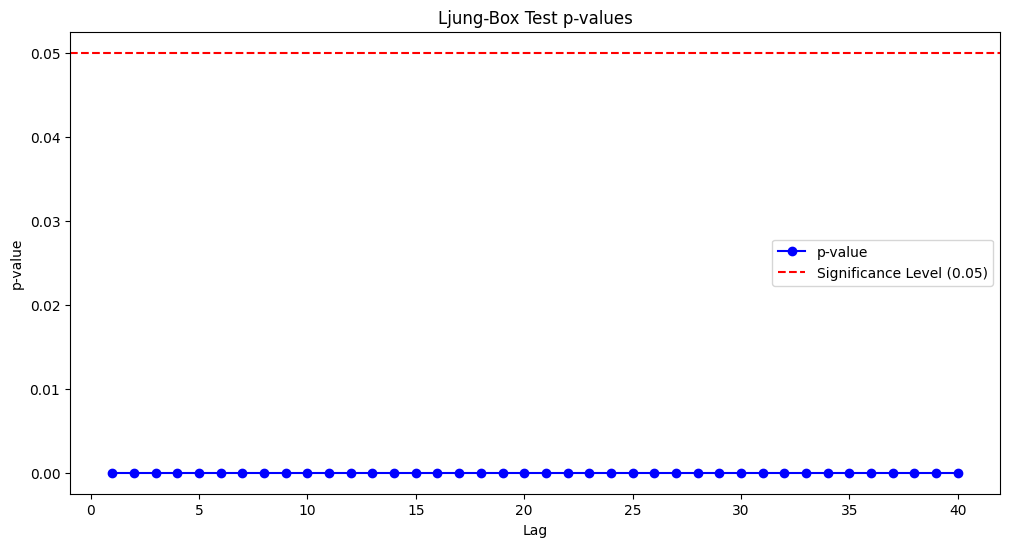


7. VIF Analysis:

            Variance Inflation Factor Results:
            -------------------------------
            No concerning multicollinearity found between your variables.

            What this means: VIF helps identify if your variables are too closely related to each other.
            - VIF > 5 suggests problematic correlation
            - VIF > 10 suggests severe correlation

            Technical details:
                    Feature      VIF
          const 2.696567
        Weekend 1.000979
Festival_Season 1.003248
  Special_Event 1.000119
  Weather_Sunny 1.002476
            

Shapiro-Wilk Test for Normality:
Statistic: 0.8807, p-value: 0.0000
The data is not normally distributed.


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import statsmodels.api as sm

class TimeSeriesAnalyzer:
    def __init__(self, data):
        """Initialize with a pandas DataFrame containing your time series data"""
        self.data = data
        self.cleaned_data = None

    def check_distribution(self):
        """Test if footfall data follows a normal distribution"""
        stat, p_value = shapiro(self.cleaned_data['Footfall'])

        interpretation = (
            "Your footfall data follows a normal distribution pattern." if p_value > 0.05 else
            "Your footfall data does not follow a normal distribution pattern. Consider using non-parametric tests."
        )

        return {
            "message": f"""
            Distribution Analysis:
            --------------------
            {interpretation}

            Technical details:
            - Shapiro-Wilk statistic: {stat:.4f}
            - p-value: {p_value:.4f}
            """
        }

    def check_autocorrelation(self, model):
        """Check for autocorrelation in the model residuals"""
        dw_stat = durbin_watson(model.resid)

        if dw_stat < 1.5:
            interpretation = "There is positive autocorrelation in your data, meaning values tend to be followed by similar values."
        elif dw_stat > 2.5:
            interpretation = "There is negative autocorrelation in your data, meaning values tend to be followed by opposite values."
        else:
            interpretation = "There is no significant autocorrelation in your data, meaning values are largely independent."

        return {
            "message": f"""
            Autocorrelation Analysis:
            -----------------------
            {interpretation}

            Technical details:
            - Durbin-Watson statistic: {dw_stat:.4f}
            - Reference: Values should be close to 2.0 for no autocorrelation
            """
        }

    def clean_outliers(self):
        """Clean outliers from footfall data using IQR method"""
        data = self.data.copy()
        Q1 = data["Footfall"].quantile(0.25)
        Q3 = data["Footfall"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data["Footfall"] < lower_bound) | (data["Footfall"] > upper_bound)]

        # Cap outliers
        data["Footfall"] = np.where(data["Footfall"] < lower_bound, lower_bound, data["Footfall"])
        data["Footfall"] = np.where(data["Footfall"] > upper_bound, upper_bound, data["Footfall"])

        result = {
            "message": f"Found {len(outliers)} outliers in Footfall data. These have been capped at {lower_bound:.2f} (lower) and {upper_bound:.2f} (upper)",
            "data": data
        }
        self.cleaned_data = data
        return result

    def compare_weekday_weekend(self):
        """Compare footfall between weekdays and weekends"""
        weekend = self.cleaned_data[self.cleaned_data["Weekend"] == 1]["Footfall"]
        weekday = self.cleaned_data[self.cleaned_data["Weekend"] == 0]["Footfall"]

        t_stat, p_value = ttest_ind(weekend, weekday)

        difference = weekend.mean() - weekday.mean()
        higher_period = "weekends" if difference > 0 else "weekdays"

        interpretation = (
            f"There is a significant difference in footfall between weekends and weekdays. "
            f"Footfall is higher during {higher_period}." if p_value <= 0.05 else
            "There is no significant difference in footfall between weekends and weekdays."
        )

        return {
            "message": f"""
            Weekend vs Weekday Analysis:
            ---------------------------
            {interpretation}

            Average footfall:
            - Weekends: {weekend.mean():.2f}
            - Weekdays: {weekday.mean():.2f}
            - Difference: {abs(difference):.2f}

            Statistical details:
            - T-statistic: {t_stat:.4f}
            - p-value: {p_value:.4f}
            """
        }

    def check_stationarity(self):
        """Test if the footfall data is stationary using Augmented Dickey-Fuller test"""
        result = adfuller(self.cleaned_data['Footfall'])

        interpretation = ("Your footfall data is stationary, meaning it's suitable for many statistical analyses."
                        if result[1] <= 0.05 else
                        "Your footfall data is not stationary. Consider differencing or transforming the data.")

        return {
            "message": f"""
            Stationarity Test Results:
            -------------------------
            {interpretation}
            Technical details:
            - ADF Statistic: {result[0]:.4f}
            - p-value: {result[1]:.4f}
            """
        }

    def perform_granger_causality(self):
        """Perform Granger Causality test to identify potential causal relationships"""
        variables = {
            'Weekend': self.cleaned_data['Weekend'],
            'Festival_Season': self.cleaned_data['Festival_Season'],
            'Special_Event': self.cleaned_data['Special_Event'],
            'Weather_Sunny': (self.cleaned_data['Weather'] == 'Sunny').astype(int)
        }

        results = {}
        interpretations = []

        for var in variables.keys():
            granger_test = grangercausalitytests(
                pd.concat([self.cleaned_data['Footfall'], variables[var]], axis=1),
                maxlag=7,
                verbose=False
            )

            # Store results and create interpretation
            min_p_value = min(test[0]['ssr_chi2test'][1] for test in granger_test.values())
            results[var] = {
                f'lag_{i+1}': test[0]['ssr_chi2test'][1]
                for i, test in enumerate(granger_test.values())
            }

            if min_p_value <= 0.05:
                interpretations.append(f"- {var} appears to have a causal relationship with Footfall")
            else:
                interpretations.append(f"- {var} shows no clear causal relationship with Footfall")

        return {
            "message": f"""
            Granger Causality Test Results:
            -----------------------------
            What this means: This test helps identify if one variable helps predict another.

            Findings:
            {chr(10).join(interpretations)}

            Technical details:
            {pd.DataFrame(results).to_string()}
            """,
            "results": results
        }

    def perform_ljung_box_test(self, lags=40):
        """Perform Ljung-Box test for autocorrelation"""
        lb_test = acorr_ljungbox(self.cleaned_data['Footfall'], lags=lags, return_df=True)

        # Create visualization
        plt.figure(figsize=(12, 6))
        plt.plot(lb_test.index, lb_test['lb_pvalue'], 'bo-', label='p-value')
        plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
        plt.xlabel('Lag')
        plt.ylabel('p-value')
        plt.title('Ljung-Box Test p-values')
        plt.legend()

        # Interpret results
        significant_lags = len(lb_test[lb_test['lb_pvalue'] <= 0.05])

        interpretation = (
            f"Found significant autocorrelation at {significant_lags} out of {lags} lags tested. "
            "This suggests there are patterns in your footfall data that repeat over time."
            if significant_lags > 0 else
            "No significant autocorrelation found, suggesting footfall values are largely independent over time."
        )

        return {
            "message": f"""
            Ljung-Box Test Results:
            ---------------------
            {interpretation}

            What this means: This test checks if your data has patterns that repeat over time.

            Technical details:
            - Number of lags tested: {lags}
            - Significant lags found: {significant_lags}
            """,
            "results": lb_test
        }

    def calculate_vif(self):
        """Calculate Variance Inflation Factor to check for multicollinearity"""
        features = pd.DataFrame({
            'Weekend': self.cleaned_data['Weekend'],
            'Festival_Season': self.cleaned_data['Festival_Season'],
            'Special_Event': self.cleaned_data['Special_Event'],
            'Weather_Sunny': (self.cleaned_data['Weather'] == 'Sunny').astype(int)
        })

        features = sm.add_constant(features)

        vif_data = pd.DataFrame()
        vif_data["Feature"] = features.columns
        vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(features.shape[1])]

        # Interpret results
        high_vif_features = vif_data[vif_data["VIF"] > 5]["Feature"].tolist()

        interpretation = (
            f"Found high multicollinearity in these features: {', '.join(high_vif_features)}. "
            "Consider removing some of these variables from your analysis."
            if high_vif_features else
            "No concerning multicollinearity found between your variables."
        )

        return {
            "message": f"""
            Variance Inflation Factor Results:
            -------------------------------
            {interpretation}

            What this means: VIF helps identify if your variables are too closely related to each other.
            - VIF > 5 suggests problematic correlation
            - VIF > 10 suggests severe correlation

            Technical details:
            {vif_data.to_string(index=False)}
            """,
            "results": vif_data
        }

    def cochrane_orcutt(self, max_iter=100):
        """Perform Cochrane-Orcutt procedure to handle autocorrelation"""
        try:
            # Prepare features
            X = pd.DataFrame({
                'Weekend': self.cleaned_data['Weekend'],
                'Festival_Season': self.cleaned_data['Festival_Season'],
                'Special_Event': self.cleaned_data['Special_Event'],
                'Weather_Sunny': (self.cleaned_data['Weather'] == 'Sunny').astype(int)
            })

            # Handle missing values
            X = X.fillna(0)  # Fill NA values with 0
            y = self.cleaned_data['Footfall'].fillna(method='ffill')  # Forward fill any missing values

            # Add constant term
            X = sm.add_constant(X)

            # Remove any remaining infinite values
            mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
            y = y[mask]
            X = X[mask]

            if len(y) == 0 or len(X) == 0:
                return {
                    "message": "Unable to perform Cochrane-Orcutt procedure due to insufficient valid data after cleaning.",
                    "model": None,
                    "rho": None
                }

            # Initial OLS regression
            model = OLS(y, X).fit()
            rho = 0.0
            best_aic = np.inf

            for _ in range(max_iter):
                # Transform variables
                y_star = y[1:] - rho * y[:-1]
                X_star = X[1:] - rho * X[:-1]

                # Re-run regression
                model = OLS(y_star, X_star).fit()

                # Calculate residuals and estimate new rho
                resid = model.resid
                rho_new = np.corrcoef(resid[1:], resid[:-1])[0,1]

                # Check convergence
                if abs(rho_new - rho) < 1e-6:
                    break

                rho = rho_new

            return {
                "message": f"""
                Cochrane-Orcutt Procedure Results:
                -------------------------------
                What this means: This procedure helps improve our model by accounting for autocorrelation.

                Findings:
                - Final correlation coefficient (rho): {rho:.4f}
                - Model R-squared: {model.rsquared:.4f}
                - Number of observations used: {len(y)}

                Interpretation:
                {"The model shows good fit with the data" if model.rsquared > 0.7 else "The model might need improvement"}
                """,
                "model": model,
                "rho": rho
            }

        except Exception as e:
            return {
                "message": f"""
                Cochrane-Orcutt Procedure Results:
                -------------------------------
                Unable to perform Cochrane-Orcutt procedure due to data issues.
                Error: {str(e)}

                This might be due to:
                - Missing values in the data
                - Infinite values in the calculations
                - Insufficient data points

                Try cleaning your data further before running this analysis.
                """,
                "model": None,
                "rho": None
            }

    def analyze_all(self):
        """Run all analyses and return comprehensive results"""
        # Clean data first
        cleaning_results = self.clean_outliers()
        print("\n1. Data Cleaning Results:")
        print(cleaning_results["message"])

        # Run all tests
        print("\n2. Stationarity Analysis:")
        print(self.check_stationarity()["message"])

        print("\n3. Weekend vs Weekday Analysis:")
        print(self.compare_weekday_weekend()["message"])

        print("\n4. Distribution Analysis:")
        print(self.check_distribution()["message"])

        print("\n5. Granger Causality Analysis:")
        print(self.perform_granger_causality()["message"])

        print("\n6. Ljung-Box Test Results:")
        lb_results = self.perform_ljung_box_test()
        print(lb_results["message"])
        plt.show()

        print("\n7. VIF Analysis:")
        print(self.calculate_vif()["message"])

def run_analysis(data):
    """Convenience function to run all analyses"""
    analyzer = TimeSeriesAnalyzer(data)
    analyzer.analyze_all()

run_analysis(data)

def shapiro_test(series):
    stat, p_value = shapiro(series)
    print("\nShapiro-Wilk Test for Normality:")
    print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value > 0.05:
        print("The data is normally distributed.")
    else:
        print("The data is not normally distributed.")

def durbin_watson_test(model):
    dw_stat = durbin_watson(model.resid)
    print("\nDurbin-Watson Test:")
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
    if dw_stat < 1.5 or dw_stat > 2.5:
        print("Evidence of autocorrelation in residuals.")
    else:
        print("No significant autocorrelation in residuals.")

shapiro_test(data['Footfall'])

In [ ]:
# Cochrane-Orcutt Procedure
def cochrane_orcutt(y, X, max_iter=100):
    # Initial OLS regression
    model = OLS(y, X).fit()
    rho = 0.0
    best_aic = np.inf

    for _ in range(max_iter):
        # Transform variables
        y_star = y[1:] - rho * y[:-1]
        X_star = X[1:] - rho * X[:-1]

        # Re-run regression
        model = OLS(y_star, X_star).fit()

        # Calculate residuals and estimate new rho
        resid = model.resid
        rho_new = np.corrcoef(resid[1:], resid[:-1])[0,1]

        # Check convergence
        if abs(rho_new - rho) < 1e-6:
            break

        rho = rho_new

    return model, rho

# Prepare data for Cochrane-Orcutt
X = pd.DataFrame({
    'Weekend': data['Weekend'],
    'Festival_Season': data['Festival_Season'],
    'Special_Event': data['Special_Event'],
    'Weather_Sunny': (data['Weather'] == 'Sunny').astype(int)
})

X = add_constant(X)
model, rho = cochrane_orcutt(data['Footfall'].values, X.values)

print("Cochrane-Orcutt Results:")
print(f"Estimated rho: {rho:.4f}")
print(f"R-squared: {model.rsquared:.4f}")


{"message": f"""
  Cochrane-Orcutt Procedure Results:
  -------------------------------
  What this means: This procedure helps improve our model by accounting for autocorrelation.

  Findings:
  - Final correlation coefficient (rho): {rho:.4f}
  - Model R-squared: {model.rsquared:.4f}
  - Number of observations used: {len(X)}

  Interpretation:
  {"The model shows good fit with the data" if model.rsquared > 0.7 else "The model might need improvement"}
  """,
  "model": model,
  "rho": rho
}

Cochrane-Orcutt Results:
Estimated rho: -0.0002
R-squared: 0.9554


{'message': '\n  Cochrane-Orcutt Procedure Results:\n  -------------------------------\n  What this means: This procedure helps improve our model by accounting for autocorrelation.\n\n  Findings:\n  - Final correlation coefficient (rho): -0.0002\n  - Model R-squared: 0.9554\n  - Number of observations used: 1461\n\n  Interpretation:\n  The model shows good fit with the data\n  ',
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7e0a87f637c0>,
 'rho': -0.0001948112443680749}

In [ ]:
# 9. Durbin-Watson Test for Autocorrelation
def durbin_watson_test(model):
    dw_stat = durbin_watson(model.resid)
    print("\nDurbin-Watson Test:")
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
    if dw_stat < 1.5 or dw_stat > 2.5:
        print("Evidence of autocorrelation in residuals.")
    else:
        print("No significant autocorrelation in residuals.")

durbin_watson_test(model)


Durbin-Watson Test:
Durbin-Watson Statistic: 2.0003
No significant autocorrelation in residuals.


In [ ]:
## model predictions


Preparing data with lagged features and date-based attributes...
Training set size: 1163 | Test set size: 291

Fitting SARIMAX model...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

SARIMAX model fitted.

Fitting VAR model...
VAR model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting Prophet model...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf41s0s_8/oel7mh42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf41s0s_8/61fw15tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62180', 'data', 'file=/tmp/tmpf41s0s_8/oel7mh42.json', 'init=/tmp/tmpf41s0s_8/61fw15tq.json', 'output', 'file=/tmp/tmpf41s0s_8/prophet_modelic2cgb7o/prophet_model-20241231072132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:21:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet model fitted.

Evaluating models...
Model evaluation completed.

Model Evaluation Metrics:

           MAE   RMSE   R^2
SARIMAX  11.43  13.89  0.90
VAR      31.71  41.21  0.09
XGBoost  12.19  15.01  0.88
Prophet  11.59  14.14  0.89


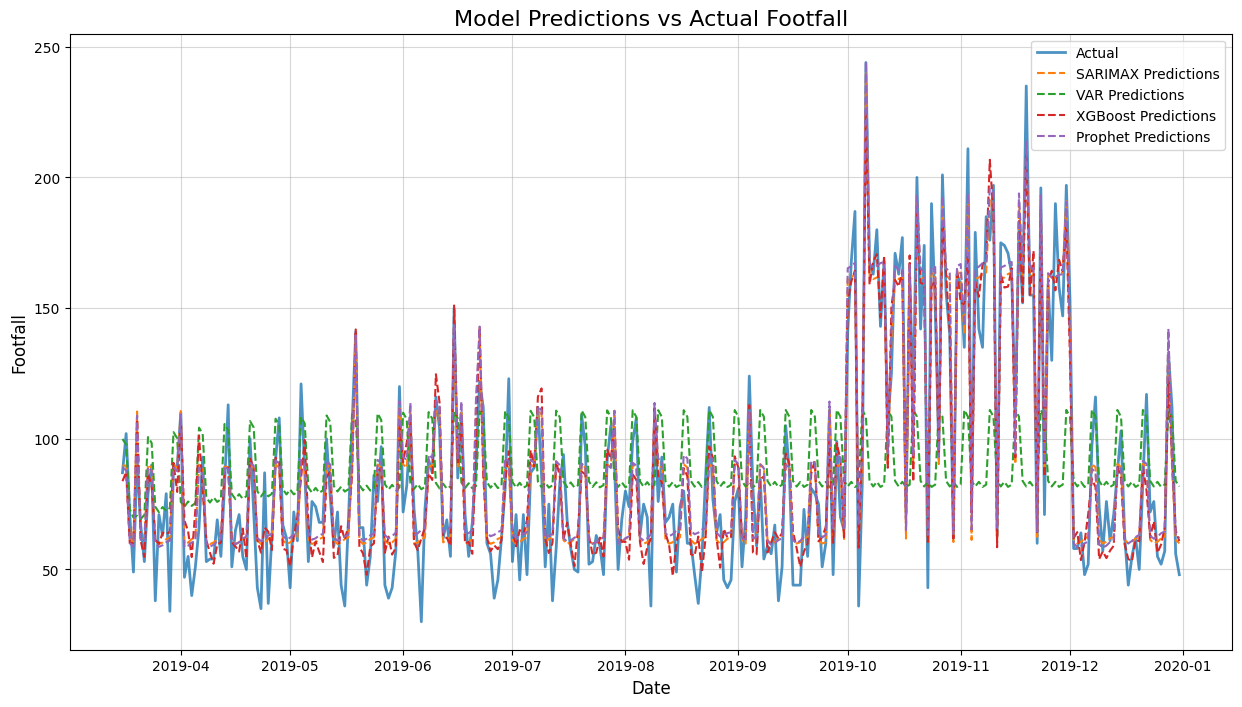

<Figure size 1000x600 with 0 Axes>

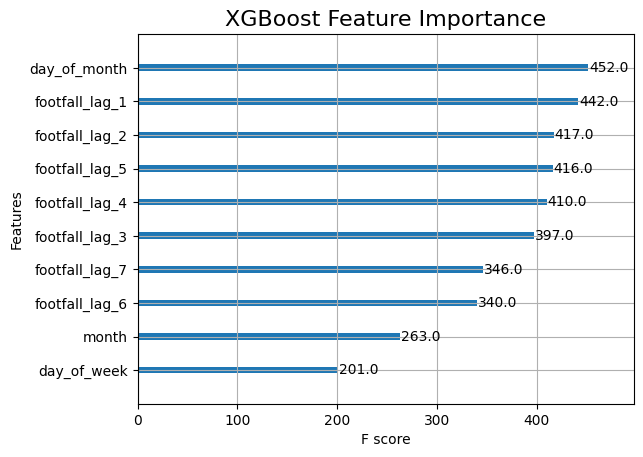

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:               Footfall   No. Observations:                 1431
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7168.551
Date:                Tue, 31 Dec 2024   AIC                          14349.102
Time:                        07:21:34   BIC                          14380.694
Sample:                    01-01-2016   HQIC                         14360.899
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7419      0.021    -35.043      0.000      -0.783      -0.700
ar.L2         -0.5699      0.026    -22.104      0.000      -0.620      -0.519
ar.L3         -0.4441      0.0

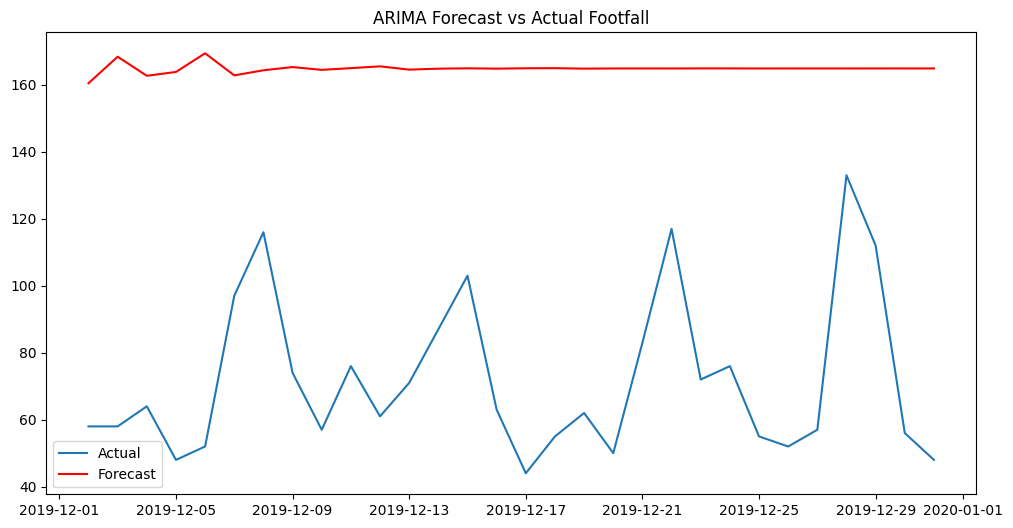

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
import xgboost as xgb
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Function to prepare data
def prepare_data(data, test_size=0.2):
    print("\nPreparing data with lagged features and date-based attributes...")
    # Create lagged features
    for i in range(1, 8):
        data[f'footfall_lag_{i}'] = data['Footfall'].shift(i)

    # Create date-based features
    data['day_of_week'] = data['Date'].dt.dayofweek
    data['month'] = data['Date'].dt.month
    data['day_of_month'] = data['Date'].dt.day

    # Drop rows with NaN from lagged features
    data = data.dropna()

    # Split data
    train_size = int(len(data) * (1 - test_size))
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    print(f"Training set size: {len(train_data)} | Test set size: {len(test_data)}")

    return train_data, test_data

# 1. SARIMAX Model
def fit_sarimax(train_data, test_data):
    print("\nFitting SARIMAX model...")
    model = SARIMAX(train_data['Footfall'],
                    exog=train_data[['Weekend', 'Festival_Season', 'Special_Event']],
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 7))
    results = model.fit(disp=False)

    predictions = results.forecast(
        steps=len(test_data),
        exog=test_data[['Weekend', 'Festival_Season', 'Special_Event']]
    )
    print("SARIMAX model fitted.")
    return predictions, results

# 2. VAR Model
def fit_var(train_data, test_data):
    print("\nFitting VAR model...")
    var_data = train_data[['Footfall', 'Weekend', 'Festival_Season', 'Special_Event']]
    model = VAR(var_data)
    results = model.fit(maxlags=7, ic='aic')

    lag_order = results.k_ar
    predictions = []
    last_data = var_data.values[-lag_order:]

    for i in range(len(test_data)):
        forecast = results.forecast(last_data, steps=1)
        predictions.append(forecast[0][0])
        last_data = np.vstack([last_data[1:], forecast])
    print("VAR model fitted.")
    return predictions, results

# 3. XGBoost Model
def fit_xgboost(train_data, test_data, feature_cols):
    print("\nFitting XGBoost model...")
    X_train = train_data[feature_cols]
    y_train = train_data['Footfall']
    X_test = test_data[feature_cols]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)  # Ensure predictions are generated
    print("XGBoost model fitted.")
    return predictions, model

# 4. Prophet Model
def fit_prophet(train_data, test_data):
    print("\nFitting Prophet model...")
    prophet_data = pd.DataFrame({
        'ds': train_data['Date'],
        'y': train_data['Footfall']
    })
    prophet_data['weekend'] = train_data['Weekend']
    prophet_data['festival'] = train_data['Festival_Season']
    prophet_data['special_event'] = train_data['Special_Event']

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.add_regressor('weekend')
    model.add_regressor('festival')
    model.add_regressor('special_event')
    model.fit(prophet_data)

    future = pd.DataFrame({
        'ds': test_data['Date'],
        'weekend': test_data['Weekend'],
        'festival': test_data['Festival_Season'],
        'special_event': test_data['Special_Event']
    })
    forecast = model.predict(future)
    predictions = forecast['yhat']
    print("Prophet model fitted.")
    return predictions, model

# Evaluate models
def evaluate_models(test_data, predictions_dict):
    print("\nEvaluating models...")
    results = {}
    for model_name, preds in predictions_dict.items():
        mae = mean_absolute_error(test_data['Footfall'], preds)
        rmse = np.sqrt(mean_squared_error(test_data['Footfall'], preds))
        r2 = r2_score(test_data['Footfall'], preds)
        results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R^2': r2}
    print("Model evaluation completed.")
    return pd.DataFrame(results).T

# Prepare data
train_data, test_data = prepare_data(data)

# Feature columns for XGBoost
feature_cols = ['Weekend', 'Festival_Season', 'Special_Event',
                'day_of_week', 'month', 'day_of_month'] + \
               [f'footfall_lag_{i}' for i in range(1, 8)]

# Fit all models
sarimax_pred, sarimax_model = fit_sarimax(train_data, test_data)
var_pred, var_model = fit_var(train_data, test_data)
xgb_pred, xgb_model = fit_xgboost(train_data, test_data, feature_cols)
prophet_pred, prophet_model = fit_prophet(train_data, test_data)

# Collect predictions
predictions = {
    'SARIMAX': sarimax_pred,
    'VAR': var_pred,
    'XGBoost': xgb_pred,
    'Prophet': prophet_pred
}

# Evaluate models
evaluation = evaluate_models(test_data, predictions)
print("\nModel Evaluation Metrics:\n")
print(evaluation.round(2))

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(test_data['Date'], test_data['Footfall'], label='Actual', alpha=0.8, linewidth=2)
for model_name, preds in predictions.items():
    plt.plot(test_data['Date'], preds, label=f'{model_name} Predictions', linestyle='--')
plt.title('Model Predictions vs Actual Footfall', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Footfall', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.show()

# ARIMA Model Performance
# Forecast

series = data.set_index("Date")["Footfall"]
train, test = series[:-30], series[-30:]

# Fit ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # (p, d, q) order
fitted_model = model.fit()
print("\nARIMA Model Summary:")
print(fitted_model.summary())

forecast = fitted_model.forecast(steps=30)

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"\nMean Squared Error of ARIMA Forecast: {mse}")

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Forecast", color="red")
plt.title("ARIMA Forecast vs Actual Footfall")
plt.legend()
plt.show()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0655 - val_loss: 0.0252
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0245 - val_loss: 0.0189
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0247 - val_loss: 0.0293
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0224 - val_loss: 0.0258
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0212 - val_loss: 0.0318
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0252 - val_loss: 0.0258
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0212 - val_loss: 0.0219
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0215 - val_loss: 0.0225
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0237 - val_loss: 0.0192
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0215 - val_loss: 0.0199
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0243 - val_l

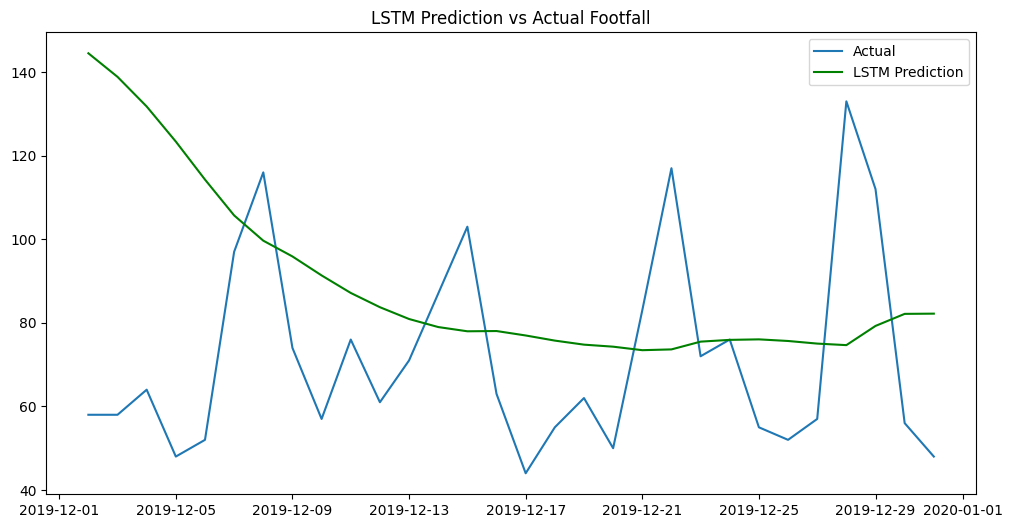

In [ ]:
# RNN with LSTM
# Prepare data for RNN
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(series.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 30
X, y = create_sequences(data_scaled, seq_length)

# Split into train and test
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation="relu", input_shape=(seq_length, 1), return_sequences=True),
    LSTM(50, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)

# Plot LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(series.index[-30:], series.values[-30:], label="Actual")
plt.plot(series.index[-30:], predictions_rescaled, label="LSTM Prediction", color="green")
plt.title("LSTM Prediction vs Actual Footfall")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Sliding Window Cross-Validation
# Sliding Window Cross-Validation
def sliding_window_cv(data, model_func, window_size, feature_cols):
    print("\nPerforming sliding window cross-validation...")
    errors = []
    for start in range(len(data) - window_size):
        train_data = data.iloc[start:start + window_size]
        test_data = data.iloc[start + window_size:start + window_size + 1]

        # Ensure predictions are returned
        predictions, _ = model_func(train_data, test_data, feature_cols)
        error = mean_squared_error(test_data['Footfall'], predictions)
        errors.append(error)
    print("Sliding window CV completed.")
    return errors

# Expanding Window Cross-Validation
def expanding_window_cv(data, model_func, feature_cols):
    print("\nPerforming expanding window cross-validation...")
    errors = []
    for i in range(1, len(data)):
        train_data = data.iloc[:i]
        test_data = data.iloc[i:i + 1]

        # Ensure predictions are returned
        predictions, _ = model_func(train_data, test_data, feature_cols)
        error = mean_squared_error(test_data['Footfall'], predictions)
        errors.append(error)
    print("Expanding window CV completed.")
    return errors

# Prediction Intervals using Bootstrapping
def prediction_intervals(data, model_func, feature_cols, n_bootstraps=100):
    print("\nCalculating prediction intervals...")
    predictions_list = []
    for _ in range(n_bootstraps):
        bootstrap_sample = data.sample(frac=1, replace=True)
        model, predictions = model_func(bootstrap_sample, data, feature_cols)
        predictions_list.append(predictions)

    predictions_array = np.array(predictions_list)
    lower_bound = np.percentile(predictions_array, 2.5, axis=0)
    upper_bound = np.percentile(predictions_array, 97.5, axis=0)
    print("Prediction intervals calculated.")
    return lower_bound, upper_bound

# Diebold-Mariano Test for Forecast Accuracy
def diebold_mariano_test(actuals, pred1, pred2):
    print("\nPerforming Diebold-Mariano test...")
    errors1 = actuals - pred1
    errors2 = actuals - pred2
    _, p_value = ttest_ind(errors1, errors2)
    print(f"Diebold-Mariano test completed. P-value: {p_value}")
    return p_value

# Plot Validation Results
def plot_validation_results(test_data, predictions, lower_bound=None, upper_bound=None):
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['Date'], test_data['Footfall'], label='Actual', alpha=0.8)
    plt.plot(test_data['Date'], predictions, label='Predictions', color='red')
    if lower_bound is not None and upper_bound is not None:
        plt.fill_between(test_data['Date'], lower_bound, upper_bound, color='gray', alpha=0.3, label='Prediction Interval')
    plt.legend()
    plt.title('Validation Results')
    plt.show()

# Example Integration (assuming SARIMAX model function already defined)
# Feature columns for models
feature_cols = ['Weekend', 'Festival_Season', 'Special_Event', 'day_of_week', 'month', 'day_of_month'] + [f'footfall_lag_{i}' for i in range(1, 8)]

# Apply sliding window cross-validation
sw_errors = sliding_window_cv(data, fit_xgboost, 30, feature_cols)
print("Sliding Window Errors:\n", sw_errors)

# Apply expanding window cross-validation
ew_errors = expanding_window_cv(data, fit_xgboost, feature_cols)
print("Expanding Window Errors:\n", ew_errors)

Streaming output truncated to the last 5000 lines.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost model fitted.

Fitting XGBoost model...
XGBoost mod